In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Data Loading 

In [2]:
from sklearn.model_selection import train_test_split

# Load the dataset 
data = pd.read_csv('processed_data_PCA.csv')

# Separate features and target
X = data.drop('y', axis=1) 
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: Check the shape of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (36167, 53)
X_test shape: (9042, 53)


smote

In [3]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(X_train, y_train)

RF model

Random Forest - Training Accuracy: 0.9521880571803935
Random Forest - Test Accuracy: 0.8869719088697191
Random Forest - Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      7951
         1.0       0.55      0.38      0.45      1091

    accuracy                           0.89      9042
   macro avg       0.73      0.67      0.69      9042
weighted avg       0.87      0.89      0.88      9042



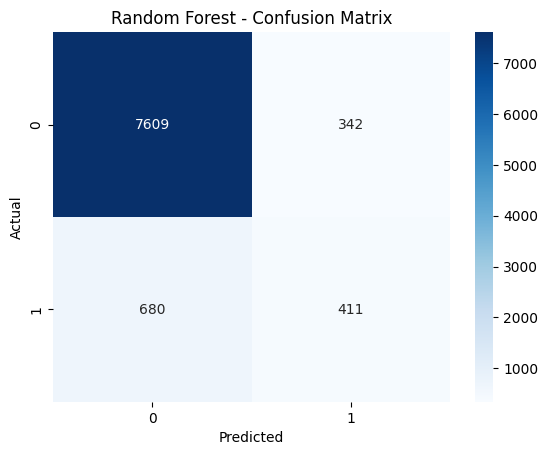

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
# rf_model = RandomForestClassifier(random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    class_weight='balanced',
    random_state=42
)

# rf_model = RandomForestClassifier(
#     n_estimators=100, 
#     max_depth=15, 
#     min_samples_split=10, 
#     min_samples_leaf=2, 
#     class_weight='balanced',
#     random_state=42
# )


# Train the model on the resampled data
rf_model.fit(x_smote, y_smote)

# Make predictions
rf_y_pred_train = rf_model.predict(x_smote)
rf_y_pred_test = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest - Training Accuracy:", accuracy_score(y_smote, rf_y_pred_train))
print("Random Forest - Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))
# # Evaluate
# print("Random Forest - Training Accuracy:", accuracy_score(y_smote, rf_y_pred_train))
# print("Random Forest - Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))

# Classification Report
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_y_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [5]:
# Get predicted probabilities for the positive class
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7902177187242531


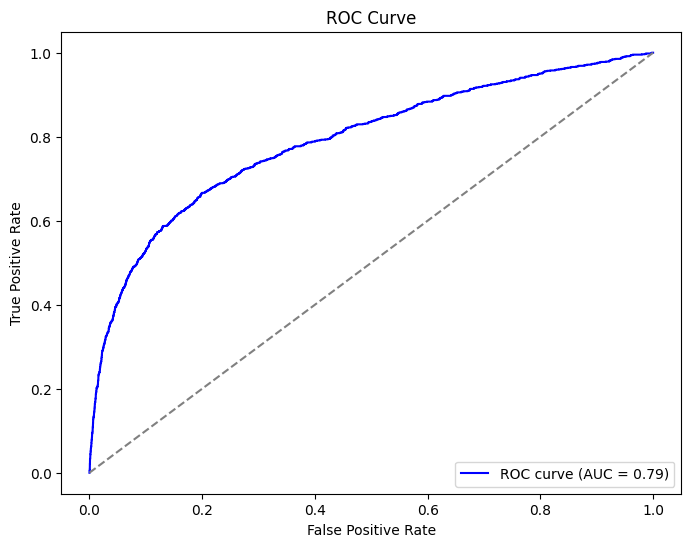

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Get ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [7]:
from sklearn.model_selection import cross_val_score

# Perform K-Fold Cross-Validation with 5 folds
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores for each fold
print(f'Cross-validation scores: {scores}')

# Print the average cross-validation score
print(f'Mean accuracy: {scores.mean()}')

Cross-validation scores: [0.88299049 0.05142668 0.18535722 0.20183588 0.14887734]
Mean accuracy: 0.29409751995878297


# Tunning

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Post-Tuning - Training Accuracy: 1.0
Random Forest Post-Tuning - Test Accuracy: 0.8891838088918381
Random Forest Post-Tuning - Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      7951
         1.0       0.58      0.29      0.39      1091

    accuracy                           0.89      9042
   macro avg       0.75      0.63      0.66      9042
weighted avg       0.87      0.89      0.87      9042



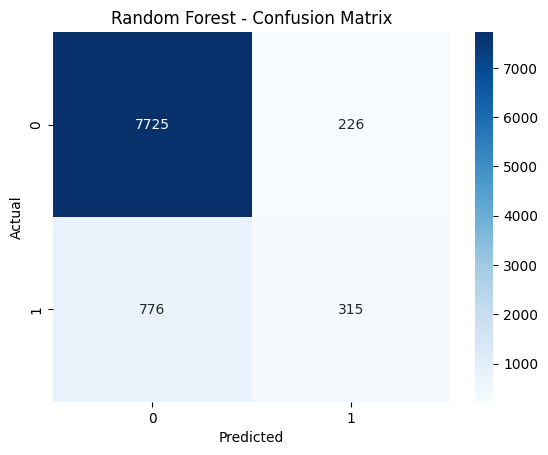

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}


# Initialize Random Forest and GridSearch
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearch
grid_search.fit(x_smote, y_smote)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_rf_model = grid_search.best_estimator_


# Make predictions
rf_tune_y_pred_train = best_rf_model.predict(x_smote)
rf_tune_y_pred_test = best_rf_model.predict(X_test)

# Evaluate
print("Random Forest Post-Tuning - Training Accuracy:", accuracy_score(y_smote, rf_tune_y_pred_train))
print("Random Forest Post-Tuning - Test Accuracy:", accuracy_score(y_test, rf_tune_y_pred_test))

# Classification Report
print("Random Forest Post-Tuning - Classification Report:")
print(classification_report(y_test, rf_tune_y_pred_test))

## Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_tune_y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
# Get predicted probabilities for the positive class
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7931968965274359


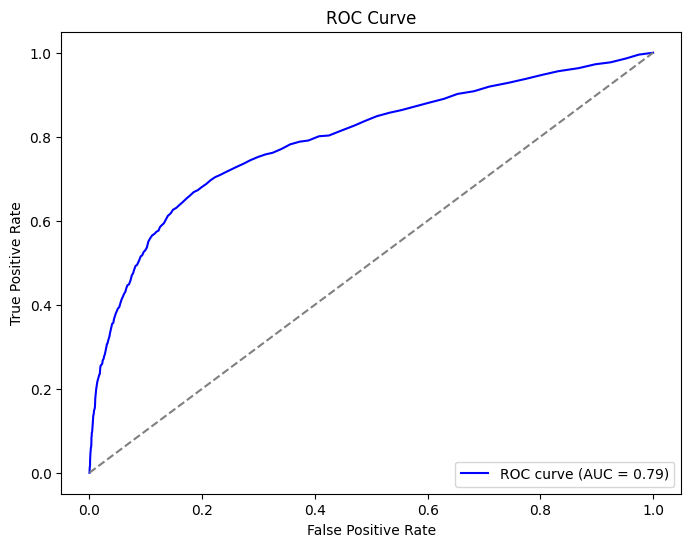

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Get ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
